<a href="https://colab.research.google.com/github/TheodorIvanov/Summer_Project/blob/master/summer_project_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Data

In [3]:
from google.colab import files # insert json token

import json # alternatively can use files.upload()
dict = {"username":"tedbg41","key":"e8b997c78473e26b4bec20ca33c9ca66"}
with open('kaggle.json', 'w') as fp:
    json.dump(dict, fp)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the Zip database from Kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzipping the file
import zipfile
with zipfile.ZipFile("creditcardfraud.zip","r") as zip_ref:
    zip_ref.extractall()

 89% 59.0M/66.0M [00:00<00:00, 83.1MB/s]
100% 66.0M/66.0M [00:00<00:00, 104MB/s] 


## Libraries

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
sns.set_palette("Set2")
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Supressing  Warnings
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

import tensorflow as tf
import keras
from keras.layers import *
from keras import losses
from keras import optimizers
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard

seed = 66

# Functions

def LossGraph(history):
  plt.figure(figsize = (12,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right');

def ReconstructionScatter(cleared, frauds, threshold): 
  plt.figure(figsize = (12,9))
  plt.scatter(cleared.index, cleared.values, marker = 'o', label = 'Cleared')
  plt.scatter(frauds.index, frauds.values, marker = 'x', label = 'Fraud')
  plt.hlines(threshold, plt.xlim()[0], plt.xlim()[1], colors = 'r', label = 'Threshold')
  plt.legend(loc = 'best')
  plt.title('Reconstructed Transactions')
  plt.xlabel('Transaction ID')
  plt.ylabel('Reconstruction Error')
  plt.show();


## Sampling

In [5]:
# Scaling the data

df = pd.read_csv('creditcard.csv')
scaled = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Time','Class'], axis=1)),
                      columns=df.drop(['Time','Class'],axis=1).columns) # scaling all columns apart from Time and Class
scaled['Class'] = df['Class']

# Splitting the data

train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

## Model 1

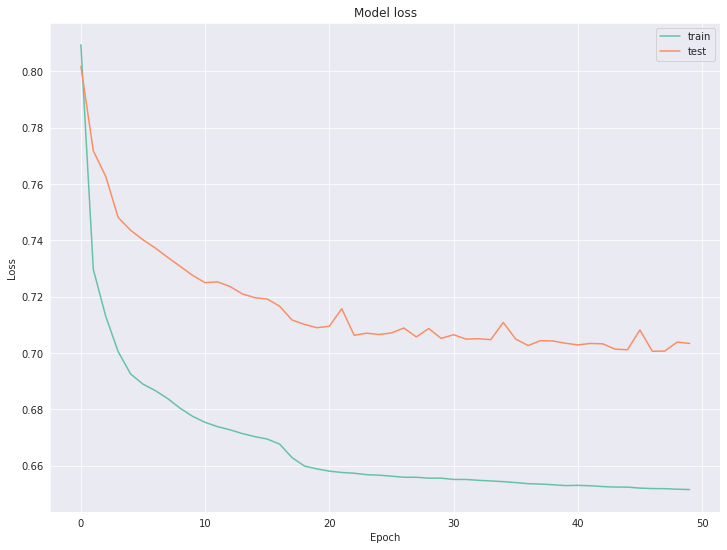

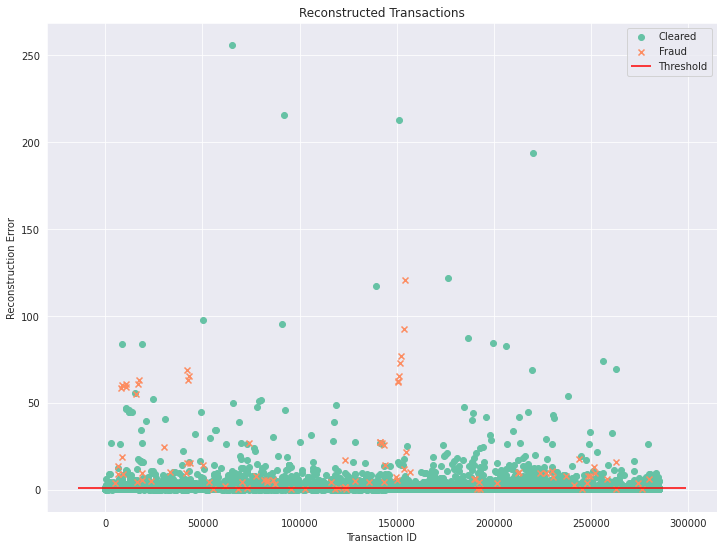

In [110]:
latent = 6 # dimension of the latent vector
batch_size = 128
epochs = 50

# Defining the Model

inputs = Input(shape=(input_dim,), name = 'input_encoder')

encoder = Dense(18, activation='relu')(inputs)
encoder = Dense(12, activation='relu')(encoder)
encoder = Dense(latent, activation='relu')(encoder)

decoder = Dense(12, activation='relu')(encoder)
decoder = Dense(18, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder_1 = Model(inputs,decoder)
# autoencoder_1.summary()
# keras.utils.plot_model(autoencoder_1, show_shapes=True)

# Compiling the model

autoencoder_1.compile(optimizer=keras.optimizers.RMSprop(),
                      loss = losses.mean_squared_error,
                      metrics = ['mae','accuracy'])

# Training

history = autoencoder_1.fit(X_train, X_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 0,
                            validation_data = (X_test, X_test))

LossGraph(history)

# Predicting

predictions = autoencoder_1.predict(X_test)

# Reconstruction error (RMSE)

rmse = np.sqrt(np.mean(np.power(X_test - predictions, 2), axis = 1))

# Reconstructed data

reconstructed = pd.DataFrame({'reconstruction_error': rmse,'true_class': y_test})

frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

ReconstructionScatter(cleared, frauds, threshold = 1)

In [ ]:
import time
for i in range(60):
  time.sleep(60)
  print(i)